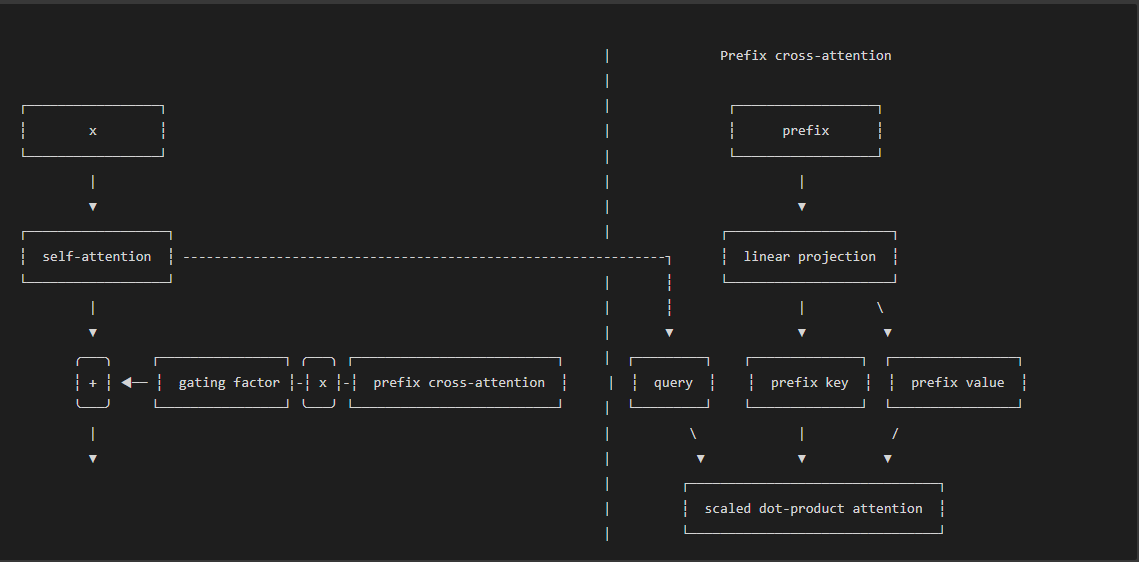

References: 
         
           LLaMA-Adapter: Efficient Fine-tuning of Language Models with Zero-init Attention
https://arxiv.org/abs/2303.16199

               LightingAI Lit-Llama



In [ ]:
import torch 
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
class LLaMAAdapter(nn.Module):

    def __init__(self, prompt_length, feature_dimension, num_layers, num_head):
        super().__init__()

        #  Learnable Adaption Prompts
        self.prompt = nn.Embedding(prompt_length, feature_dimension)

        # Zero Init Attention with Gating
        self.gating_factors = nn.Parameter(torch.zeros(1, feature_dimension))

        # k, q, v, projections
        self.c_attn = nn.Linear(feature_dimension, 3 * feature_dimension, bias=False)

        # Output projection
        self.c_proj = nn.Linear(feature_dimension, 3 * feature_dimension , bias=False)

    def forward(self, input_tokens, attention_mask):

        q, k, v = self.c_attn(input_tokens).split(self.feature_dimensions, dim=2)

        # Atention score for M + 1 (Word Tokens)
        y = F.scaled_dot_product_attention(q, k, v, attn_mask=attention_mask, dropout_p=0.1)

        _, prefix_key, prefix_value = self.c_attn(self.prompt).split(self.feature_dimensions, dim=2)

        # Atention score for K (Adaption Prompt)
        prefix_y = F.scaled_dot_product_attention(q, prefix_key, prefix_value, attn_mask=attention_mask, dropout_p=0.1)
        
        # Add a learnable gating factor, to adaptively control the importance prefix_y in the attention.
        y = y + self.gating_factors * prefix_y
        
        y = self.c_proj(y)

        return y 